### Install liten
Must install latest tendb before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ liten
```
Read local setup.py and install tendb
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten/dist/liten-0.0.1-py3-none-any.whl
```

Import Apache arrow

In [1]:
import pyarrow as pa
from pyarrow import csv
import json
import pandas as pd

Import Liten-ten is local rten is remote. rten imports pyarrow library as well.

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Import Ray to be used as a cluster

In [3]:
import ray

Start a cluster with single worker.

In [4]:
ray.init(num_cpus=1)

2022-01-06 19:06:15,956	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.29.223.147',
 'raylet_ip_address': '172.29.223.147',
 'redis_address': '172.29.223.147:6379',
 'object_store_address': '/tmp/ray/session_2022-01-06_19-06-15_348518_6887/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-01-06_19-06-15_348518_6887/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-01-06_19-06-15_348518_6887',
 'metrics_export_port': 55351,
 'node_id': '3aacc6e8357ea7ba64a7feb34e327df2e95eee6b'}

In [5]:
ray.cluster_resources()

{'CPU': 1.0,
 'memory': 78.0,
 'object_store_memory': 27.0,
 'node:172.29.223.147': 1.0}

Create a Liten Cache Actor. It is residing on a remote node, and being executed on that node. tc is the Liten Cache actor handle.

In [6]:
ten.Cache = ray.remote(ten.Cache)
tc = ten.Cache.remote()

These are fact and dimension tables of TPCH. Read them remotely.

In [7]:
fact_tables = ['lineitem']
dim_tables = ['customer','orders','supplier','nation','region','partsupp','part']
tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'

In [8]:
def read_tables(tables, table_type):
    tc_tables = []
    for table_name in tables:
        tpch_table = tpch_dir+table_name+'.tbl'
        print('Reading ', tpch_table)
        csv_options = pa.csv.ParseOptions(delimiter='|')
        table = tc.read_csv.remote(input_file=tpch_table, parse_options=csv_options, table_name=table_name, ttype=table_type)
        # print(' Rows=', pytable.num_rows,' Cols=', pytable.num_columns)
        tc_tables.append(table)
    return tc_tables

In [9]:
%%time
fact_tables = ray.get(read_tables(fact_tables, ten.Cache.FactTable))
fact_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/lineitem.tbl


(pid=6984) <frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
(pid=6984) <frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject
(pid=6984) WARNING: Logging before InitGoogleLogging() is written to STDERR
(pid=6984) I20220106 19:06:17.785874  6984 TCache.cpp:25] Created a new TCache


CPU times: user 204 ms, sys: 92.2 ms, total: 296 ms
Wall time: 5.25 s


(pid=6984) I20220106 19:06:22.888797  6984 TCatalog.cpp:15] Created a new TCatalog


['lineitem']

In [10]:
dim_tables = ray.get(read_tables(dim_tables, ten.Cache.DimensionTable))
dim_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/customer.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/orders.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/supplier.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/nation.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/region.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/partsupp.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/part.tbl


['customer', 'orders', 'supplier', 'nation', 'region', 'partsupp', 'part']

In [11]:
ray.get(tc.info.remote())

b'{"Compute":{"WorkerThreads":0},"Table":{"part":"DimensionTable","partsupp":"DimensionTable","region":"DimensionTable","customer":"DimensionTable","lineitem":"FactTable","orders":"DimensionTable","supplier":"DimensionTable","nation":"DimensionTable"},"Schema":{"region_schema":"DimensionTable","part_schema":"DimensionTable","lineitem_schema":"FactTable","orders_schema":"DimensionTable","partsupp_schema":"DimensionTable","customer_schema":"DimensionTable","supplier_schema":"DimensionTable","nation_schema":"DimensionTable"}}'

In [12]:
pd.read_json(ray.get(tc.schema_info.remote()))

(pid=6984) I20220106 19:06:24.617084  6984 TConfigs.cpp:17] Created a new TConfigs


,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


In [13]:
pd.read_json(ray.get(tc.schema_info.remote()))

,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


Join all the parents and child of tensor dimensions and fact tables

In [14]:
ray.get(tc.join.remote('lineitem_schema','L_ORDERKEY','orders_schema','O_ORDERKEY'))
ray.get(tc.join.remote('lineitem_schema','L_SUPPKEY','supplier_schema','S_SUPPKEY'))
ray.get(tc.join.remote('orders_schema','O_CUSTKEY','customer_schema','C_CUSTKEY'))
ray.get(tc.join.remote('customer_schema','C_NATIONKEY','nation_schema','N_NATIONKEY'))
ray.get(tc.join.remote('nation_schema','N_REGIONKEY','region_schema','R_REGIONKEY'))
ray.get(tc.join.remote('supplier_schema','S_NATIONKEY', 'nation_schema', 'N_NATIONKEY'))

True

In [15]:
def get_schemas():
    schemas = { }
    def add_schema(table_name):
        schema_name = table_name + "_schema"
        schema_info = ray.get(tc.get_schema_info.remote(schema_name))
        schemas[schema_name] = json.loads(schema_info)
    for i in range(len(fact_tables)):
        add_schema(fact_tables[i])
    for i in range(len(dim_tables)):
        add_schema(dim_tables[i])
    return schemas

In [16]:
schemas = get_schemas()
pd.DataFrame(schemas['lineitem_schema']['schema'])

,fields,name,parent,type
L_COMMENT,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_COMMITDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable
L_DISCOUNT,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_EXTENDEDPRICE,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINENUMBER,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINESTATUS,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_ORDERKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[orders_schema, O_ORDERKEY]",FactTable
L_PARTKEY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_QUANTITY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_RECEIPTDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable


In [17]:
pd.DataFrame(schemas['orders_schema']['schema'])

,child,fields,name,parent,type
O_ORDERKEY,"[lineitem_schema, L_ORDERKEY]","{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,NaN,DimensionTable
O_CLERK,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_COMMENT,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_CUSTKEY,NaN,"{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,"[customer_schema, C_CUSTKEY]",DimensionTable
O_ORDERDATE,NaN,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",orders_schema,NaN,DimensionTable
O_ORDERPRIORITY,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_ORDERSTATUS,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_SHIPPRIORITY,NaN,"{'datatype': 'int64', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_TOTALPRICE,NaN,"{'datatype': 'double', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable


Create remote tensor

In [18]:
%%time
ray.get(tc.make_tensor.remote())

(pid=6984) I20220106 19:06:25.581408  6984 TTable.cpp:520] Created tensor for part
(pid=6984) I20220106 19:06:25.581441  6984 TTable.cpp:520] Created tensor for partsupp
(pid=6984) I20220106 19:06:25.581465  6984 TTable.cpp:520] Created tensor for region
(pid=6984) I20220106 19:06:25.762707  6984 TTable.h:355] Joined child table=customer col=C_NATIONKEY parent table=nation col=N_NATIONKEY
(pid=6984) I20220106 19:06:25.762754  6984 TTable.cpp:520] Created tensor for customer
(pid=6984) I20220106 19:06:31.867331  6984 TTable.h:355] Joined child table=lineitem col=L_ORDERKEY parent table=orders col=O_ORDERKEY
(pid=6984) I20220106 19:06:35.609302  6984 TTable.h:355] Joined child table=lineitem col=L_SUPPKEY parent table=supplier col=S_SUPPKEY
(pid=6984) I20220106 19:06:35.609361  6984 TTable.cpp:520] Created tensor for lineitem


CPU times: user 321 ms, sys: 77.5 ms, total: 398 ms
Wall time: 12.4 s


True

Read Arrow table

(pid=6984)  TPCH QUERY 6 
(pid=6984) SELECT 
(pid=6984)   SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
(pid=6984) FROM 
(pid=6984)   LINEITEM
(pid=6984) WHERE
(pid=6984)   L_SHIPDATE >= DATE '1997-01-01'
(pid=6984)   AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
(pid=6984)   AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
(pid=6984)   AND L_QUANTITY < 25;
(pid=6984) 
(pid=6984) Revenue= 156594095.60960016
(pid=6984) 
(pid=6984) Time(ms)= 118.9981
(pid=6984) 


(pid=6984) I20220106 19:06:37.284968  6984 TTable.h:355] Joined child table=orders col=O_CUSTKEY parent table=customer col=C_CUSTKEY
(pid=6984) I20220106 19:06:37.285028  6984 TTable.cpp:520] Created tensor for orders
(pid=6984) I20220106 19:06:37.288758  6984 TTable.h:355] Joined child table=supplier col=S_NATIONKEY parent table=nation col=N_NATIONKEY
(pid=6984) I20220106 19:06:37.288782  6984 TTable.cpp:520] Created tensor for supplier
(pid=6984) I20220106 19:06:37.288827  6984 TTable.h:355] Joined child table=nation col=N_REGIONKEY parent table=region col=R_REGIONKEY
(pid=6984) I20220106 19:06:37.288839  6984 TTable.cpp:520] Created tensor for nation
(pid=6984) I20220106 19:06:37.300391  6984 TpchDemo.cpp:99] Found table lineitem in cache
(pid=6984) I20220106 19:06:37.300438  6984 TpchDemo.cpp:99] Found table customer in cache
(pid=6984) I20220106 19:06:37.300453  6984 TpchDemo.cpp:99] Found table orders in cache
(pid=6984) I20220106 19:06:37.300480  6984 TpchDemo.cpp:99] Found tabl

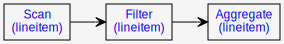

In [19]:
ray.get(tc.query6.remote())

In [20]:
ray.get(tc.query5.remote())

(pid=6984) I20220106 19:06:37.479703  6984 TpchDemo.cpp:99] Found table lineitem in cache
(pid=6984) I20220106 19:06:37.479750  6984 TpchDemo.cpp:99] Found table customer in cache
(pid=6984) I20220106 19:06:37.479763  6984 TpchDemo.cpp:99] Found table orders in cache
(pid=6984) I20220106 19:06:37.479773  6984 TpchDemo.cpp:99] Found table supplier in cache
(pid=6984) I20220106 19:06:37.479782  6984 TpchDemo.cpp:99] Found table nation in cache
(pid=6984) I20220106 19:06:37.479795  6984 TpchDemo.cpp:99] Found table region in cache
(pid=6984) I20220106 19:06:37.480139  6984 TpchDemo.cpp:549] Query5 Processing block=0


(pid=6984)  
(pid=6984) SELECT
(pid=6984) 	N_NAME,
(pid=6984) 	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
(pid=6984) FROM
(pid=6984) 	CUSTOMER,
(pid=6984) 	ORDERS,
(pid=6984) 	LINEITEM,
(pid=6984) 	SUPPLIER,
(pid=6984) 	NATION,
(pid=6984) 	REGION
(pid=6984) WHERE
(pid=6984) 	C_CUSTKEY = O_CUSTKEY
(pid=6984) 	AND L_ORDERKEY = O_ORDERKEY
(pid=6984) 	AND L_SUPPKEY = S_SUPPKEY
(pid=6984) 	AND C_NATIONKEY = S_NATIONKEY
(pid=6984) 	AND S_NATIONKEY = N_NATIONKEY
(pid=6984) 	AND N_REGIONKEY = R_REGIONKEY
(pid=6984) 	AND R_NAME = 'EUROPE'
(pid=6984) 	AND O_ORDERDATE >= DATE '1995-01-01'
(pid=6984) 	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
(pid=6984) GROUP BY
(pid=6984) 	N_NAME
(pid=6984) ORDER BY
(pid=6984) 	REVENUE DESC;
(pid=6984) 


(pid=6984) I20220106 19:06:37.519618  6984 TpchDemo.cpp:681]  Query 5  Blk 0 Total Rows = 8543 Filtered rows=2061 Elapsed ns=36670000 Total lookup time ns=23608400 Expr eval time ns=5369500 Orders Time ns= 12500300 Nation Time ns= 2103200 Region Time ns= 2015800
(pid=6984) I20220106 19:06:37.519682  6984 TpchDemo.cpp:549] Query5 Processing block=1
(pid=6984) I20220106 19:06:37.559892  6984 TpchDemo.cpp:681]  Query 5  Blk 1 Total Rows = 8482 Filtered rows=1515 Elapsed ns=37402200 Total lookup time ns=24565500 Expr eval time ns=5151500 Orders Time ns= 13260400 Nation Time ns= 2281000 Region Time ns= 1995600
(pid=6984) I20220106 19:06:37.559965  6984 TpchDemo.cpp:549] Query5 Processing block=2
(pid=6984) I20220106 19:06:37.604451  6984 TpchDemo.cpp:681]  Query 5  Blk 2 Total Rows = 8466 Filtered rows=7169 Elapsed ns=41615000 Total lookup time ns=20198000 Expr eval time ns=13201400 Orders Time ns= 13193400 Nation Time ns= 475500 Region Time ns= 464800
(pid=6984) I20220106 19:06:37.604580  

(pid=6984) I20220106 19:06:38.216331  6984 TpchDemo.cpp:681]  Query 5  Blk 27 Total Rows = 8395 Filtered rows=2089 Elapsed ns=26183400 Total lookup time ns=16431900 Expr eval time ns=4085700 Orders Time ns= 8359900 Nation Time ns= 1426400 Region Time ns= 1330400
(pid=6984) I20220106 19:06:38.216372  6984 TpchDemo.cpp:549] Query5 Processing block=28
(pid=6984) I20220106 19:06:38.243073  6984 TpchDemo.cpp:681]  Query 5  Blk 28 Total Rows = 8398 Filtered rows=1446 Elapsed ns=24673600 Total lookup time ns=15299900 Expr eval time ns=3355700 Orders Time ns= 8331900 Nation Time ns= 1110100 Region Time ns= 1073800
(pid=6984) I20220106 19:06:38.243129  6984 TpchDemo.cpp:549] Query5 Processing block=29
(pid=6984) I20220106 19:06:38.269294  6984 TpchDemo.cpp:681]  Query 5  Blk 29 Total Rows = 8411 Filtered rows=3864 Elapsed ns=24200600 Total lookup time ns=12938500 Expr eval time ns=5593100 Orders Time ns= 8474100 Nation Time ns= 110300 Region Time ns= 106200
(pid=6984) I20220106 19:06:38.269345 

(pid=6984) I20220106 19:06:38.788697  6984 TpchDemo.cpp:681]  Query 5  Blk 50 Total Rows = 8403 Filtered rows=1329 Elapsed ns=23847200 Total lookup time ns=15277400 Expr eval time ns=3066400 Orders Time ns= 8004300 Nation Time ns= 1201900 Region Time ns= 1128100
(pid=6984) I20220106 19:06:38.788741  6984 TpchDemo.cpp:549] Query5 Processing block=51
(pid=6984) I20220106 19:06:38.815320  6984 TpchDemo.cpp:681]  Query 5  Blk 51 Total Rows = 8409 Filtered rows=3385 Elapsed ns=24531400 Total lookup time ns=13404200 Expr eval time ns=5542700 Orders Time ns= 8789000 Nation Time ns= 101700 Region Time ns= 100600
(pid=6984) I20220106 19:06:38.815371  6984 TpchDemo.cpp:549] Query5 Processing block=52
(pid=6984) I20220106 19:06:38.837159  6984 TpchDemo.cpp:681]  Query 5  Blk 52 Total Rows = 8406 Filtered rows=0 Elapsed ns=19787600 Total lookup time ns=12645200 Expr eval time ns=1573100 Orders Time ns= 8500100 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:38.837203  6984 TpchDemo.

(pid=6984) I20220106 19:06:39.511915  6984 TpchDemo.cpp:549] Query5 Processing block=76
(pid=6984) I20220106 19:06:39.543066  6984 TpchDemo.cpp:681]  Query 5  Blk 76 Total Rows = 8404 Filtered rows=1764 Elapsed ns=28883800 Total lookup time ns=18384000 Expr eval time ns=4030200 Orders Time ns= 9383400 Nation Time ns= 1664000 Region Time ns= 1643200
(pid=6984) I20220106 19:06:39.543102  6984 TpchDemo.cpp:549] Query5 Processing block=77
(pid=6984) I20220106 19:06:39.570091  6984 TpchDemo.cpp:681]  Query 5  Blk 77 Total Rows = 8409 Filtered rows=661 Elapsed ns=24540100 Total lookup time ns=16010700 Expr eval time ns=2510400 Orders Time ns= 9303400 Nation Time ns= 826300 Region Time ns= 837400
(pid=6984) I20220106 19:06:39.570149  6984 TpchDemo.cpp:549] Query5 Processing block=78
(pid=6984) I20220106 19:06:39.595408  6984 TpchDemo.cpp:681]  Query 5  Blk 78 Total Rows = 8408 Filtered rows=14 Elapsed ns=22967600 Total lookup time ns=14845900 Expr eval time ns=1941300 Orders Time ns= 9835200 

(pid=6984) I20220106 19:06:40.167829  6984 TpchDemo.cpp:681]  Query 5  Blk 99 Total Rows = 8396 Filtered rows=926 Elapsed ns=25336300 Total lookup time ns=16304700 Expr eval time ns=2934900 Orders Time ns= 9295500 Nation Time ns= 907200 Region Time ns= 902700
(pid=6984) I20220106 19:06:40.167870  6984 TpchDemo.cpp:549] Query5 Processing block=100
(pid=6984) I20220106 19:06:40.191013  6984 TpchDemo.cpp:681]  Query 5  Blk 100 Total Rows = 8400 Filtered rows=20 Elapsed ns=21038300 Total lookup time ns=13269300 Expr eval time ns=1805900 Orders Time ns= 8545400 Nation Time ns= 107600 Region Time ns= 99900
(pid=6984) I20220106 19:06:40.191056  6984 TpchDemo.cpp:549] Query5 Processing block=101
(pid=6984) I20220106 19:06:40.215942  6984 TpchDemo.cpp:681]  Query 5  Blk 101 Total Rows = 8394 Filtered rows=428 Elapsed ns=22756500 Total lookup time ns=14518600 Expr eval time ns=2230900 Orders Time ns= 8939700 Nation Time ns= 310500 Region Time ns= 341500
(pid=6984) I20220106 19:06:40.215987  6984

(pid=6984) I20220106 19:06:40.839946  6984 TpchDemo.cpp:681]  Query 5  Blk 121 Total Rows = 8336 Filtered rows=3795 Elapsed ns=32060600 Total lookup time ns=18443500 Expr eval time ns=6812600 Orders Time ns= 10633700 Nation Time ns= 1111600 Region Time ns= 1061400
(pid=6984) I20220106 19:06:40.840000  6984 TpchDemo.cpp:549] Query5 Processing block=122
(pid=6984) I20220106 19:06:40.869525  6984 TpchDemo.cpp:681]  Query 5  Blk 122 Total Rows = 8336 Filtered rows=0 Elapsed ns=27013300 Total lookup time ns=17504000 Expr eval time ns=2215500 Orders Time ns= 11969500 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:40.869626  6984 TpchDemo.cpp:549] Query5 Processing block=123
(pid=6984) I20220106 19:06:40.897603  6984 TpchDemo.cpp:681]  Query 5  Blk 123 Total Rows = 8340 Filtered rows=78 Elapsed ns=25509700 Total lookup time ns=16712400 Expr eval time ns=2019600 Orders Time ns= 10846000 Nation Time ns= 160700 Region Time ns= 149500
(pid=6984) I20220106 19:06:40.897651  6984 Tpc

(pid=6984) I20220106 19:06:41.627466  6984 TpchDemo.cpp:681]  Query 5  Blk 146 Total Rows = 8335 Filtered rows=1547 Elapsed ns=29339200 Total lookup time ns=18844700 Expr eval time ns=3805600 Orders Time ns= 9582500 Nation Time ns= 1635800 Region Time ns= 1618300
(pid=6984) I20220106 19:06:41.627501  6984 TpchDemo.cpp:549] Query5 Processing block=147
(pid=6984) I20220106 19:06:41.659723  6984 TpchDemo.cpp:681]  Query 5  Blk 147 Total Rows = 8352 Filtered rows=1698 Elapsed ns=29809000 Total lookup time ns=18938100 Expr eval time ns=4091400 Orders Time ns= 9810700 Nation Time ns= 1566800 Region Time ns= 1505400
(pid=6984) I20220106 19:06:41.659776  6984 TpchDemo.cpp:549] Query5 Processing block=148
(pid=6984) I20220106 19:06:41.688218  6984 TpchDemo.cpp:681]  Query 5  Blk 148 Total Rows = 8345 Filtered rows=258 Elapsed ns=26055100 Total lookup time ns=16904800 Expr eval time ns=2260200 Orders Time ns= 10635300 Nation Time ns= 384100 Region Time ns= 375000
(pid=6984) I20220106 19:06:41.68

(pid=6984) I20220106 19:06:42.282371  6984 TpchDemo.cpp:681]  Query 5  Blk 168 Total Rows = 8342 Filtered rows=1577 Elapsed ns=26971700 Total lookup time ns=17182000 Expr eval time ns=3558400 Orders Time ns= 9134000 Nation Time ns= 1328600 Region Time ns= 1342400
(pid=6984) I20220106 19:06:42.282413  6984 TpchDemo.cpp:549] Query5 Processing block=169
(pid=6984) I20220106 19:06:42.313055  6984 TpchDemo.cpp:681]  Query 5  Blk 169 Total Rows = 8335 Filtered rows=1711 Elapsed ns=28282300 Total lookup time ns=17978400 Expr eval time ns=3867800 Orders Time ns= 9243900 Nation Time ns= 1594600 Region Time ns= 1606000
(pid=6984) I20220106 19:06:42.313097  6984 TpchDemo.cpp:549] Query5 Processing block=170
(pid=6984) I20220106 19:06:42.341588  6984 TpchDemo.cpp:681]  Query 5  Blk 170 Total Rows = 8333 Filtered rows=499 Elapsed ns=26008100 Total lookup time ns=16930300 Expr eval time ns=2390500 Orders Time ns= 10492100 Nation Time ns= 374300 Region Time ns= 408100
(pid=6984) I20220106 19:06:42.34

(pid=6984) I20220106 19:06:42.943392  6984 TpchDemo.cpp:681]  Query 5  Blk 191 Total Rows = 8332 Filtered rows=1691 Elapsed ns=28997300 Total lookup time ns=18156400 Expr eval time ns=4076500 Orders Time ns= 9556800 Nation Time ns= 1516300 Region Time ns= 1516400
(pid=6984) I20220106 19:06:42.943447  6984 TpchDemo.cpp:549] Query5 Processing block=192
(pid=6984) I20220106 19:06:42.969923  6984 TpchDemo.cpp:681]  Query 5  Blk 192 Total Rows = 8331 Filtered rows=670 Elapsed ns=24275700 Total lookup time ns=15496500 Expr eval time ns=2577900 Orders Time ns= 9398100 Nation Time ns= 490500 Region Time ns= 521800
(pid=6984) I20220106 19:06:42.969969  6984 TpchDemo.cpp:549] Query5 Processing block=193
(pid=6984) I20220106 19:06:43.003974  6984 TpchDemo.cpp:681]  Query 5  Blk 193 Total Rows = 8326 Filtered rows=7699 Elapsed ns=31732500 Total lookup time ns=14346600 Expr eval time ns=10805800 Orders Time ns= 9525800 Nation Time ns= 90500 Region Time ns= 86300
(pid=6984) I20220106 19:06:43.004022

(pid=6984) I20220106 19:06:43.607118  6984 TpchDemo.cpp:681]  Query 5  Blk 214 Total Rows = 8331 Filtered rows=5337 Elapsed ns=28359000 Total lookup time ns=15004100 Expr eval time ns=7287300 Orders Time ns= 8696400 Nation Time ns= 734100 Region Time ns= 683700
(pid=6984) I20220106 19:06:43.607153  6984 TpchDemo.cpp:549] Query5 Processing block=215
(pid=6984) I20220106 19:06:43.629731  6984 TpchDemo.cpp:681]  Query 5  Blk 215 Total Rows = 8335 Filtered rows=0 Elapsed ns=20475600 Total lookup time ns=13021400 Expr eval time ns=1721300 Orders Time ns= 8580600 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:43.629774  6984 TpchDemo.cpp:549] Query5 Processing block=216
(pid=6984) I20220106 19:06:43.654253  6984 TpchDemo.cpp:681]  Query 5  Blk 216 Total Rows = 8332 Filtered rows=564 Elapsed ns=22266200 Total lookup time ns=14247000 Expr eval time ns=2247500 Orders Time ns= 8542400 Nation Time ns= 449500 Region Time ns= 435200
(pid=6984) I20220106 19:06:43.654343  6984 TpchDem

(pid=6984) I20220106 19:06:44.274060  6984 TpchDemo.cpp:681]  Query 5  Blk 239 Total Rows = 8332 Filtered rows=1837 Elapsed ns=25495000 Total lookup time ns=16353400 Expr eval time ns=3568400 Orders Time ns= 8463400 Nation Time ns= 1350900 Region Time ns= 1357000
(pid=6984) I20220106 19:06:44.274098  6984 TpchDemo.cpp:549] Query5 Processing block=240
(pid=6984) I20220106 19:06:44.301170  6984 TpchDemo.cpp:681]  Query 5  Blk 240 Total Rows = 8353 Filtered rows=1633 Elapsed ns=24998300 Total lookup time ns=15685600 Expr eval time ns=3479200 Orders Time ns= 8293500 Nation Time ns= 1274400 Region Time ns= 1240100
(pid=6984) I20220106 19:06:44.301229  6984 TpchDemo.cpp:549] Query5 Processing block=241
(pid=6984) I20220106 19:06:44.323104  6984 TpchDemo.cpp:681]  Query 5  Blk 241 Total Rows = 8327 Filtered rows=110 Elapsed ns=19788200 Total lookup time ns=12627100 Expr eval time ns=1626200 Orders Time ns= 8142300 Nation Time ns= 139900 Region Time ns= 138100
(pid=6984) I20220106 19:06:44.323

(pid=6984) I20220106 19:06:44.945659  6984 TpchDemo.cpp:681]  Query 5  Blk 265 Total Rows = 8336 Filtered rows=1073 Elapsed ns=23795300 Total lookup time ns=15227000 Expr eval time ns=2827600 Orders Time ns= 8453400 Nation Time ns= 934500 Region Time ns= 908000
(pid=6984) I20220106 19:06:44.945709  6984 TpchDemo.cpp:549] Query5 Processing block=266
(pid=6984) I20220106 19:06:44.974972  6984 TpchDemo.cpp:681]  Query 5  Blk 266 Total Rows = 8346 Filtered rows=2014 Elapsed ns=27112800 Total lookup time ns=17189100 Expr eval time ns=4027100 Orders Time ns= 8856200 Nation Time ns= 1562500 Region Time ns= 1401100
(pid=6984) I20220106 19:06:44.975047  6984 TpchDemo.cpp:549] Query5 Processing block=267
(pid=6984) I20220106 19:06:45.000708  6984 TpchDemo.cpp:681]  Query 5  Blk 267 Total Rows = 8338 Filtered rows=1025 Elapsed ns=23596700 Total lookup time ns=15133400 Expr eval time ns=2907200 Orders Time ns= 8582800 Nation Time ns= 812400 Region Time ns= 814800
(pid=6984) I20220106 19:06:45.0007

(pid=6984) I20220106 19:06:45.660511  6984 TpchDemo.cpp:681]  Query 5  Blk 288 Total Rows = 8324 Filtered rows=1357 Elapsed ns=32408500 Total lookup time ns=21154600 Expr eval time ns=4152600 Orders Time ns= 11029700 Nation Time ns= 1966000 Region Time ns= 1898800
(pid=6984) I20220106 19:06:45.660565  6984 TpchDemo.cpp:549] Query5 Processing block=289
(pid=6984) I20220106 19:06:45.691227  6984 TpchDemo.cpp:681]  Query 5  Blk 289 Total Rows = 8338 Filtered rows=1137 Elapsed ns=28256200 Total lookup time ns=17850200 Expr eval time ns=3559400 Orders Time ns= 10357600 Nation Time ns= 982300 Region Time ns= 931500
(pid=6984) I20220106 19:06:45.691277  6984 TpchDemo.cpp:549] Query5 Processing block=290
(pid=6984) I20220106 19:06:45.717648  6984 TpchDemo.cpp:681]  Query 5  Blk 290 Total Rows = 8318 Filtered rows=20 Elapsed ns=23994100 Total lookup time ns=15624200 Expr eval time ns=1850700 Orders Time ns= 10074200 Nation Time ns= 125400 Region Time ns= 119600
(pid=6984) I20220106 19:06:45.717

(pid=6984) I20220106 19:06:46.459311  6984 TpchDemo.cpp:681]  Query 5  Blk 312 Total Rows = 8316 Filtered rows=3803 Elapsed ns=30639600 Total lookup time ns=16410400 Expr eval time ns=6948500 Orders Time ns= 10639700 Nation Time ns= 133400 Region Time ns= 128000
(pid=6984) I20220106 19:06:46.459360  6984 TpchDemo.cpp:549] Query5 Processing block=313
(pid=6984) I20220106 19:06:46.486411  6984 TpchDemo.cpp:681]  Query 5  Blk 313 Total Rows = 8349 Filtered rows=212 Elapsed ns=24276300 Total lookup time ns=15303400 Expr eval time ns=2223100 Orders Time ns= 9852500 Nation Time ns= 194800 Region Time ns= 183200
(pid=6984) I20220106 19:06:46.486454  6984 TpchDemo.cpp:549] Query5 Processing block=314
(pid=6984) I20220106 19:06:46.522444  6984 TpchDemo.cpp:681]  Query 5  Blk 314 Total Rows = 8327 Filtered rows=2063 Elapsed ns=33417700 Total lookup time ns=21025100 Expr eval time ns=5152200 Orders Time ns= 11177400 Nation Time ns= 1697100 Region Time ns= 1742300
(pid=6984) I20220106 19:06:46.522

(pid=6984) I20220106 19:06:47.222147  6984 TpchDemo.cpp:681]  Query 5  Blk 335 Total Rows = 8337 Filtered rows=0 Elapsed ns=26471700 Total lookup time ns=17181400 Expr eval time ns=2118400 Orders Time ns= 11634000 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:47.222306  6984 TpchDemo.cpp:549] Query5 Processing block=336
(pid=6984) I20220106 19:06:47.261837  6984 TpchDemo.cpp:681]  Query 5  Blk 336 Total Rows = 8339 Filtered rows=1812 Elapsed ns=36765300 Total lookup time ns=23795600 Expr eval time ns=5130400 Orders Time ns= 12651400 Nation Time ns= 2127100 Region Time ns= 1957600
(pid=6984) I20220106 19:06:47.261937  6984 TpchDemo.cpp:549] Query5 Processing block=337
(pid=6984) I20220106 19:06:47.304247  6984 TpchDemo.cpp:681]  Query 5  Blk 337 Total Rows = 8334 Filtered rows=1482 Elapsed ns=39303400 Total lookup time ns=25978200 Expr eval time ns=5068000 Orders Time ns= 13502200 Nation Time ns= 2647900 Region Time ns= 2495900
(pid=6984) I20220106 19:06:47.304623  6984

(pid=6984) I20220106 19:06:48.096695  6984 TpchDemo.cpp:681]  Query 5  Blk 359 Total Rows = 8346 Filtered rows=1765 Elapsed ns=31840600 Total lookup time ns=20358900 Expr eval time ns=4484800 Orders Time ns= 10410600 Nation Time ns= 1891500 Region Time ns= 1798200
(pid=6984) I20220106 19:06:48.096823  6984 TpchDemo.cpp:549] Query5 Processing block=360
(pid=6984) I20220106 19:06:48.125133  6984 TpchDemo.cpp:681]  Query 5  Blk 360 Total Rows = 8325 Filtered rows=504 Elapsed ns=25708600 Total lookup time ns=16214700 Expr eval time ns=2615000 Orders Time ns= 10145700 Nation Time ns= 360300 Region Time ns= 385500
(pid=6984) I20220106 19:06:48.125180  6984 TpchDemo.cpp:549] Query5 Processing block=361
(pid=6984) I20220106 19:06:48.156575  6984 TpchDemo.cpp:681]  Query 5  Blk 361 Total Rows = 8342 Filtered rows=23 Elapsed ns=28497800 Total lookup time ns=18855300 Expr eval time ns=2074600 Orders Time ns= 12509500 Nation Time ns= 172800 Region Time ns= 130600
(pid=6984) I20220106 19:06:48.1566

(pid=6984) I20220106 19:06:48.772377  6984 TpchDemo.cpp:681]  Query 5  Blk 382 Total Rows = 8345 Filtered rows=810 Elapsed ns=24463000 Total lookup time ns=15474100 Expr eval time ns=2701900 Orders Time ns= 9219300 Nation Time ns= 658200 Region Time ns= 646600
(pid=6984) I20220106 19:06:48.772423  6984 TpchDemo.cpp:549] Query5 Processing block=383
(pid=6984) I20220106 19:06:48.798045  6984 TpchDemo.cpp:681]  Query 5  Blk 383 Total Rows = 8338 Filtered rows=17 Elapsed ns=23146700 Total lookup time ns=15058100 Expr eval time ns=1727700 Orders Time ns= 9939200 Nation Time ns= 108300 Region Time ns= 105300
(pid=6984) I20220106 19:06:48.798092  6984 TpchDemo.cpp:549] Query5 Processing block=384
(pid=6984) I20220106 19:06:48.823321  6984 TpchDemo.cpp:681]  Query 5  Blk 384 Total Rows = 8318 Filtered rows=507 Elapsed ns=23079400 Total lookup time ns=14565200 Expr eval time ns=2363400 Orders Time ns= 8771000 Nation Time ns= 499200 Region Time ns= 490100
(pid=6984) I20220106 19:06:48.823370  69

(pid=6984) I20220106 19:06:49.342000  6984 TpchDemo.cpp:681]  Query 5  Blk 404 Total Rows = 8324 Filtered rows=4260 Elapsed ns=27130000 Total lookup time ns=14966800 Expr eval time ns=6224900 Orders Time ns= 8571100 Nation Time ns= 810300 Region Time ns= 807700
(pid=6984) I20220106 19:06:49.342056  6984 TpchDemo.cpp:549] Query5 Processing block=405
(pid=6984) I20220106 19:06:49.365492  6984 TpchDemo.cpp:681]  Query 5  Blk 405 Total Rows = 8345 Filtered rows=16 Elapsed ns=21319000 Total lookup time ns=13857000 Expr eval time ns=1772900 Orders Time ns= 8987800 Nation Time ns= 137200 Region Time ns= 131300
(pid=6984) I20220106 19:06:49.365530  6984 TpchDemo.cpp:549] Query5 Processing block=406
(pid=6984) I20220106 19:06:49.388183  6984 TpchDemo.cpp:681]  Query 5  Blk 406 Total Rows = 8342 Filtered rows=317 Elapsed ns=20712300 Total lookup time ns=13174200 Expr eval time ns=1934200 Orders Time ns= 8168100 Nation Time ns= 238200 Region Time ns= 222200
(pid=6984) I20220106 19:06:49.388240  6

(pid=6984) I20220106 19:06:50.234781  6984 TpchDemo.cpp:681]  Query 5  Blk 430 Total Rows = 8337 Filtered rows=2034 Elapsed ns=44797800 Total lookup time ns=28904800 Expr eval time ns=6752300 Orders Time ns= 14738600 Nation Time ns= 2745100 Region Time ns= 2571000
(pid=6984) I20220106 19:06:50.234843  6984 TpchDemo.cpp:549] Query5 Processing block=431
(pid=6984) I20220106 19:06:50.272363  6984 TpchDemo.cpp:681]  Query 5  Blk 431 Total Rows = 8334 Filtered rows=332 Elapsed ns=34359800 Total lookup time ns=23004300 Expr eval time ns=2983200 Orders Time ns= 14382900 Nation Time ns= 701400 Region Time ns= 704600
(pid=6984) I20220106 19:06:50.272437  6984 TpchDemo.cpp:549] Query5 Processing block=432
(pid=6984) I20220106 19:06:50.305011  6984 TpchDemo.cpp:681]  Query 5  Blk 432 Total Rows = 8325 Filtered rows=0 Elapsed ns=29632800 Total lookup time ns=19563800 Expr eval time ns=2229400 Orders Time ns= 13495400 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:50.305065  6984 Tp

(pid=6984) I20220106 19:06:50.890676  6984 TpchDemo.cpp:681]  Query 5  Blk 452 Total Rows = 8335 Filtered rows=1620 Elapsed ns=30880000 Total lookup time ns=20188500 Expr eval time ns=4117600 Orders Time ns= 10431900 Nation Time ns= 1827800 Region Time ns= 1837800
(pid=6984) I20220106 19:06:50.890724  6984 TpchDemo.cpp:549] Query5 Processing block=453
(pid=6984) I20220106 19:06:50.923053  6984 TpchDemo.cpp:681]  Query 5  Blk 453 Total Rows = 8338 Filtered rows=6408 Elapsed ns=30130100 Total lookup time ns=14949100 Expr eval time ns=8930700 Orders Time ns= 9218800 Nation Time ns= 452700 Region Time ns= 448300
(pid=6984) I20220106 19:06:50.923116  6984 TpchDemo.cpp:549] Query5 Processing block=454
(pid=6984) I20220106 19:06:50.946456  6984 TpchDemo.cpp:681]  Query 5  Blk 454 Total Rows = 8332 Filtered rows=0 Elapsed ns=21229400 Total lookup time ns=13513800 Expr eval time ns=1659200 Orders Time ns= 8918300 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:50.946504  6984 Tpc

(pid=6984) I20220106 19:06:51.542749  6984 TpchDemo.cpp:681]  Query 5  Blk 477 Total Rows = 8316 Filtered rows=666 Elapsed ns=22010000 Total lookup time ns=14079300 Expr eval time ns=2300800 Orders Time ns= 8350400 Nation Time ns= 532300 Region Time ns= 513000
(pid=6984) I20220106 19:06:51.542793  6984 TpchDemo.cpp:549] Query5 Processing block=478
(pid=6984) I20220106 19:06:51.570050  6984 TpchDemo.cpp:681]  Query 5  Blk 478 Total Rows = 8333 Filtered rows=1505 Elapsed ns=25132300 Total lookup time ns=16045600 Expr eval time ns=3384500 Orders Time ns= 8144100 Nation Time ns= 1470800 Region Time ns= 1383200
(pid=6984) I20220106 19:06:51.570128  6984 TpchDemo.cpp:549] Query5 Processing block=479
(pid=6984) I20220106 19:06:51.599249  6984 TpchDemo.cpp:681]  Query 5  Blk 479 Total Rows = 8346 Filtered rows=1284 Elapsed ns=26990600 Total lookup time ns=17594200 Expr eval time ns=3336300 Orders Time ns= 9443100 Nation Time ns= 1389900 Region Time ns= 1346600
(pid=6984) I20220106 19:06:51.599

(pid=6984) I20220106 19:06:52.168983  6984 TpchDemo.cpp:681]  Query 5  Blk 499 Total Rows = 8336 Filtered rows=770 Elapsed ns=33561500 Total lookup time ns=22130700 Expr eval time ns=3355900 Orders Time ns= 14349500 Nation Time ns= 575600 Region Time ns= 527100
(pid=6984) I20220106 19:06:52.169034  6984 TpchDemo.cpp:549] Query5 Processing block=500
(pid=6984) I20220106 19:06:52.209983  6984 TpchDemo.cpp:681]  Query 5  Blk 500 Total Rows = 8328 Filtered rows=1934 Elapsed ns=38122600 Total lookup time ns=24910500 Expr eval time ns=5600800 Orders Time ns= 13026900 Nation Time ns= 2508900 Region Time ns= 2229000
(pid=6984) I20220106 19:06:52.210034  6984 TpchDemo.cpp:549] Query5 Processing block=501
(pid=6984) I20220106 19:06:52.241564  6984 TpchDemo.cpp:681]  Query 5  Blk 501 Total Rows = 8325 Filtered rows=1361 Elapsed ns=29224800 Total lookup time ns=19060400 Expr eval time ns=3691100 Orders Time ns= 9913700 Nation Time ns= 1675300 Region Time ns= 1605900
(pid=6984) I20220106 19:06:52.2

(pid=6984) I20220106 19:06:52.860038  6984 TpchDemo.cpp:681]  Query 5  Blk 524 Total Rows = 8342 Filtered rows=154 Elapsed ns=21378600 Total lookup time ns=13675300 Expr eval time ns=1790600 Orders Time ns= 8677400 Nation Time ns= 209100 Region Time ns= 213800
(pid=6984) I20220106 19:06:52.860070  6984 TpchDemo.cpp:549] Query5 Processing block=525
(pid=6984) I20220106 19:06:52.887648  6984 TpchDemo.cpp:681]  Query 5  Blk 525 Total Rows = 8340 Filtered rows=0 Elapsed ns=25171400 Total lookup time ns=16716900 Expr eval time ns=1885100 Orders Time ns= 11395600 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:52.887708  6984 TpchDemo.cpp:549] Query5 Processing block=526
(pid=6984) I20220106 19:06:52.921842  6984 TpchDemo.cpp:681]  Query 5  Blk 526 Total Rows = 8333 Filtered rows=819 Elapsed ns=31576000 Total lookup time ns=21152400 Expr eval time ns=3405500 Orders Time ns= 11874100 Nation Time ns= 1616100 Region Time ns= 1507200
(pid=6984) I20220106 19:06:52.921898  6984 Tpch

(pid=6984) I20220106 19:06:53.736533  6984 TpchDemo.cpp:681]  Query 5  Blk 552 Total Rows = 8339 Filtered rows=556 Elapsed ns=23374600 Total lookup time ns=14939200 Expr eval time ns=2377000 Orders Time ns= 9209400 Nation Time ns= 382500 Region Time ns= 341100
(pid=6984) I20220106 19:06:53.736558  6984 TpchDemo.cpp:549] Query5 Processing block=553
(pid=6984) I20220106 19:06:53.767879  6984 TpchDemo.cpp:681]  Query 5  Blk 553 Total Rows = 8341 Filtered rows=1582 Elapsed ns=29098200 Total lookup time ns=18825000 Expr eval time ns=3796600 Orders Time ns= 9592700 Nation Time ns= 1755500 Region Time ns= 1769400
(pid=6984) I20220106 19:06:53.767933  6984 TpchDemo.cpp:549] Query5 Processing block=554
(pid=6984) I20220106 19:06:53.800671  6984 TpchDemo.cpp:681]  Query 5  Blk 554 Total Rows = 8331 Filtered rows=1929 Elapsed ns=30395900 Total lookup time ns=19430300 Expr eval time ns=4479700 Orders Time ns= 10017700 Nation Time ns= 1713700 Region Time ns= 1633800
(pid=6984) I20220106 19:06:53.80

(pid=6984) I20220106 19:06:54.407768  6984 TpchDemo.cpp:681]  Query 5  Blk 579 Total Rows = 8330 Filtered rows=1218 Elapsed ns=22164400 Total lookup time ns=14113400 Expr eval time ns=2775000 Orders Time ns= 7850800 Nation Time ns= 915900 Region Time ns= 876000
(pid=6984) I20220106 19:06:54.407804  6984 TpchDemo.cpp:549] Query5 Processing block=580
(pid=6984) I20220106 19:06:54.433465  6984 TpchDemo.cpp:681]  Query 5  Blk 580 Total Rows = 8337 Filtered rows=1977 Elapsed ns=23691800 Total lookup time ns=14908200 Expr eval time ns=3586400 Orders Time ns= 7815700 Nation Time ns= 1208200 Region Time ns= 1187600
(pid=6984) I20220106 19:06:54.433504  6984 TpchDemo.cpp:549] Query5 Processing block=581
(pid=6984) I20220106 19:06:54.457108  6984 TpchDemo.cpp:681]  Query 5  Blk 581 Total Rows = 8350 Filtered rows=650 Elapsed ns=21721100 Total lookup time ns=14057800 Expr eval time ns=2261000 Orders Time ns= 8099300 Nation Time ns= 761100 Region Time ns= 697400
(pid=6984) I20220106 19:06:54.45715

(pid=6984) I20220106 19:06:55.084594  6984 TpchDemo.cpp:681]  Query 5  Blk 608 Total Rows = 8314 Filtered rows=89 Elapsed ns=22876000 Total lookup time ns=15264300 Expr eval time ns=1791600 Orders Time ns= 10044100 Nation Time ns= 155400 Region Time ns= 168600
(pid=6984) I20220106 19:06:55.084659  6984 TpchDemo.cpp:549] Query5 Processing block=609
(pid=6984) I20220106 19:06:55.106914  6984 TpchDemo.cpp:681]  Query 5  Blk 609 Total Rows = 8324 Filtered rows=0 Elapsed ns=20248000 Total lookup time ns=13095300 Expr eval time ns=1547300 Orders Time ns= 8902900 Nation Time ns= 0 Region Time ns= 0
(pid=6984) I20220106 19:06:55.106961  6984 TpchDemo.cpp:549] Query5 Processing block=610
(pid=6984) I20220106 19:06:55.130846  6984 TpchDemo.cpp:681]  Query 5  Blk 610 Total Rows = 8332 Filtered rows=1506 Elapsed ns=22046400 Total lookup time ns=13723400 Expr eval time ns=2975000 Orders Time ns= 7618200 Nation Time ns= 839200 Region Time ns= 823200
(pid=6984) I20220106 19:06:55.130887  6984 TpchDem

(pid=6984) I20220106 19:06:55.739706  6984 TpchDemo.cpp:681]  Query 5  Blk 637 Total Rows = 8334 Filtered rows=1878 Elapsed ns=22377600 Total lookup time ns=14009700 Expr eval time ns=3321700 Orders Time ns= 7239600 Nation Time ns= 1200800 Region Time ns= 1133500
(pid=6984) I20220106 19:06:55.739725  6984 TpchDemo.cpp:549] Query5 Processing block=638
(pid=6984) I20220106 19:06:55.764688  6984 TpchDemo.cpp:681]  Query 5  Blk 638 Total Rows = 8330 Filtered rows=1861 Elapsed ns=23072900 Total lookup time ns=14699100 Expr eval time ns=3278200 Orders Time ns= 7740100 Nation Time ns= 1205900 Region Time ns= 1180200
(pid=6984) I20220106 19:06:55.764724  6984 TpchDemo.cpp:549] Query5 Processing block=639
(pid=6984) I20220106 19:06:55.796525  6984 TpchDemo.cpp:681]  Query 5  Blk 639 Total Rows = 8338 Filtered rows=7998 Elapsed ns=29737700 Total lookup time ns=13675700 Expr eval time ns=10101600 Orders Time ns= 9122000 Nation Time ns= 56000 Region Time ns= 54800
(pid=6984) I20220106 19:06:55.796

(pid=6984) I20220106 19:06:56.343147  6984 TpchDemo.cpp:681]  Query 5  Blk 663 Total Rows = 8347 Filtered rows=1247 Elapsed ns=22225200 Total lookup time ns=14094100 Expr eval time ns=2770200 Orders Time ns= 7858500 Nation Time ns= 1018000 Region Time ns= 864900
(pid=6984) I20220106 19:06:56.343181  6984 TpchDemo.cpp:549] Query5 Processing block=664
(pid=6984) I20220106 19:06:56.368620  6984 TpchDemo.cpp:681]  Query 5  Blk 664 Total Rows = 8323 Filtered rows=1857 Elapsed ns=23511000 Total lookup time ns=14877200 Expr eval time ns=3344600 Orders Time ns= 7696100 Nation Time ns= 1259600 Region Time ns= 1210900
(pid=6984) I20220106 19:06:56.368659  6984 TpchDemo.cpp:549] Query5 Processing block=665
(pid=6984) I20220106 19:06:56.390857  6984 TpchDemo.cpp:681]  Query 5  Blk 665 Total Rows = 8333 Filtered rows=747 Elapsed ns=20383000 Total lookup time ns=12959000 Expr eval time ns=2161000 Orders Time ns= 7457400 Nation Time ns= 653900 Region Time ns= 651700
(pid=6984) I20220106 19:06:56.3909

(pid=6984) I20220106 19:06:57.032563  6984 TpchDemo.cpp:681]  Query 5  Blk 692 Total Rows = 8338 Filtered rows=87 Elapsed ns=34887200 Total lookup time ns=23212200 Expr eval time ns=2927000 Orders Time ns= 15368000 Nation Time ns= 90400 Region Time ns= 88600
(pid=6984) I20220106 19:06:57.032624  6984 TpchDemo.cpp:549] Query5 Processing block=693
(pid=6984) I20220106 19:06:57.056363  6984 TpchDemo.cpp:681]  Query 5  Blk 693 Total Rows = 8343 Filtered rows=15 Elapsed ns=21590300 Total lookup time ns=14201200 Expr eval time ns=1618900 Orders Time ns= 9204400 Nation Time ns= 94700 Region Time ns= 90600
(pid=6984) I20220106 19:06:57.056411  6984 TpchDemo.cpp:549] Query5 Processing block=694
(pid=6984) I20220106 19:06:57.083156  6984 TpchDemo.cpp:681]  Query 5  Blk 694 Total Rows = 8348 Filtered rows=1208 Elapsed ns=24714200 Total lookup time ns=15849000 Expr eval time ns=3091500 Orders Time ns= 8790300 Nation Time ns= 1068500 Region Time ns= 1062400
(pid=6984) I20220106 19:06:57.083199  698

2022-01-06 19:06:57,836	WARNING worker.py:1034 -- A worker died or was killed while executing task ffffffffffffffffdf5a1a8201000000.


RayActorError: The actor died unexpectedly before finishing this task.

This will kill remote Liten Cache.

In [ ]:
ray.kill(tc)

Shut down ray now

In [ ]:
ray.shutdown()